In [ ]:
if 0:
    from google.colab import drive
    drive.mount('/content/drive')
if 0:
    !cp -r /content/drive/MyDrive/HomeWork5 /content/
!pip install tensorflow-addons
#kaggle datasets download -d athota1/caltech101
if 0:
  ! pip install --upgrade --force-reinstall --no-deps kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c digit-recognizer

  ! unzip digit-recognizer.zip -d /content/digit-recognizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
X_train = np.load('/content/drive/MyDrive/HW5-gear/HW5-gear/data/DataForClassification_TimeDomain.npy')
X_train = np.transpose(X_train)

Y_train = np.zeros((936, 1))
label = 0

for i in range(936):
    Y_train[i] = label
    if (i % 104 == 0) and (i != 0):
        label = label + 1

# PyTorch tensor kullanımı
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train).long()

# Train-Test Split
X_dev, X_test, Y_dev, Y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, shuffle=True, random_state=0)

# Dimension arttırma
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(ImprovedGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Initialize model
input_size = X_train.shape[2]
hidden_size = 64
output_size = 9
model = ImprovedGRUModel(input_size, hidden_size, output_size)

# Loss ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

    # Validation accuracy
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_accuracy = (torch.argmax(val_outputs, dim=1) == Y_val.squeeze()).sum().item() / len(Y_val)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')
    model.train()

# Test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_accuracy = (torch.argmax(test_outputs, dim=1) == Y_test.squeeze()).sum().item() / len(Y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')

# Save
torch.save(model.state_dict(), '/content/drive/MyDrive/gru_model')


Epoch 1/50, Loss: 2.1610, Val Accuracy: 0.2600
Epoch 2/50, Loss: 2.1444, Val Accuracy: 0.3267
Epoch 3/50, Loss: 2.1370, Val Accuracy: 0.3733
Epoch 4/50, Loss: 2.1100, Val Accuracy: 0.4067
Epoch 5/50, Loss: 2.0686, Val Accuracy: 0.4267
Epoch 6/50, Loss: 2.0284, Val Accuracy: 0.4667
Epoch 7/50, Loss: 2.0056, Val Accuracy: 0.4733
Epoch 8/50, Loss: 1.9423, Val Accuracy: 0.5067
Epoch 9/50, Loss: 1.9885, Val Accuracy: 0.5067
Epoch 10/50, Loss: 1.8704, Val Accuracy: 0.5600
Epoch 11/50, Loss: 1.9344, Val Accuracy: 0.6000
Epoch 12/50, Loss: 1.8091, Val Accuracy: 0.6267
Epoch 13/50, Loss: 1.8082, Val Accuracy: 0.6333
Epoch 14/50, Loss: 1.7497, Val Accuracy: 0.6600
Epoch 15/50, Loss: 1.6462, Val Accuracy: 0.6867
Epoch 16/50, Loss: 1.6398, Val Accuracy: 0.7000
Epoch 17/50, Loss: 1.6747, Val Accuracy: 0.7000
Epoch 18/50, Loss: 1.5752, Val Accuracy: 0.6933
Epoch 19/50, Loss: 1.5330, Val Accuracy: 0.7000
Epoch 20/50, Loss: 1.5420, Val Accuracy: 0.6933
Epoch 21/50, Loss: 1.3678, Val Accuracy: 0.7133
E

In [ ]:
# Yükleme işlemi
loaded_model = ImprovedGRUModel(input_size, hidden_size, output_size)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/gru_model'))
loaded_model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_accuracy = (torch.argmax(test_outputs, dim=1) == Y_test.squeeze()).sum().item() / len(Y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9149


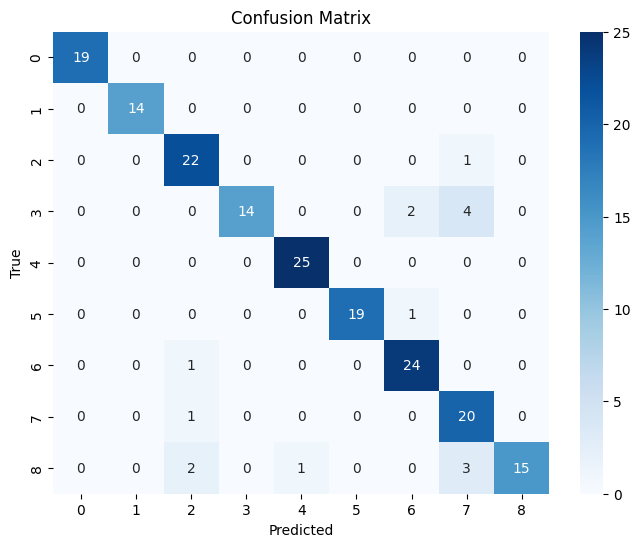

Accuracy: 0.9149


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.argmax(test_outputs, dim=1).numpy()
    true_labels = Y_test.squeeze().numpy()

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# ACC hesaplama
accuracy = accuracy_score(true_labels, predictions)

class_names = [str(i) for i in range(9)]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy:.4f}')
